二手车交易价格预测
- 赛题：https://tianchi.aliyun.com/competition/entrance/231784/introduction
- 赛题理解
    - 赛题概况
    - 数据理解
    - 预测指标（目标函数）
    
- 探索性数据分析
    - 缺失值检测
    - 异常值检测
    - 总体分布情况
    - 特征的峰度偏度等
    - 相关性
    - 缺失值处理 - 插值、高维映射、预测、分箱
    - 异常值处理 - 箱线图、box-cox、长尾截断
    - 数据分箱 - 等频、等距、Best-KS、卡方
    - 特征归一化、标准化、幂函数

- 特征工程
    - 特征构造
        - 统计量特征：计数、求和、比例、标准差
        - 时间特征：绝对和相对时间、节假日、双休日
        - 空间特诊：分值、分布编码
        - 非线性变换：log/平方/根号
        - 特征组合、特征交叉
    - 特征选择
        - 过滤式（filter）:先对数据进行特征选择，再训练学习器
            - Relief
            - 方差选择
            - 相关系数
            - 卡方检验
            - 互信息
        - 包裹式（wrapper）：直接把学习器的性能表现作为特征子集的评价标准
            - LVM:Las Vegas Wrapper
        - 嵌入式（embedding）：结合过滤式和包裹式，学习器训练过程中自动进行了特征选择
            - lasso回归
            - ridge回归
            - 决策树
    - 降维
        - PCA
        - LDA
        - LCA
        
- 建模调参
    - 线性回归：对特征要求、标签变化、长尾分布
    - 模型验证：
        - 函数
            - 评价函数
            - 目标函数
        - 方法
            - 交叉验证
            - 留一法验证
            - 针对时间序列问题的验证
        - 实现
            - 学习率曲线
            - 验证曲线
    - 模型调参
        - 贪心调参
        - 网格调参
        - 贝叶斯调参
- 模型融合
    - 简单加权融合
        - 回归（算数平均融合，几何平均融合）
        - 分类（投票，voting）
        - 综合（排序融合 rank averaging, log融合）
    - boosting/bagging
        - XGBoost，Adaboost，GBDT中用到的多树提升方法
    - stacking/blending
        - 构建多层模型，利用预测结果再拟合预测

数据理解
- 二手车交易真实记录。数据量超过40w，15列为匿名变量。其中对name，model，brank和regioncode进行了脱敏处理
    - name - 汽车编码
    - regData - 汽车注册时间
    - model - 车型编码
    - brank - 品牌
    - bodyType - 车身类型
    - gearbox - 变速箱
    - power - 汽车功率
    - kilometer - 汽车行驶公里
    - notRepairedDamage - 汽车有尚未修复的损坏
    - regionCode - 看车地区编码
    - seller - 销售方
    - offerType - 报价类型
    - createData - 广告发布时间
    - price - 汽车价格
    - v0~v14: 根据汽车评论、标签等大量信息得到的embedding向量，人工构造匿名特征。数据全部脱敏处理，都为label encoding的数字形式

In [7]:
## 基础工具
import numpy as np
import pandas as pd
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import jn
from IPython.display import display, clear_output
import time
warnings.filterwarnings('ignore')
%matplotlib inline

## 模型预测的
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

## 数据降维处理的
from sklearn.decomposition import PCA,FastICA,FactorAnalysis,SparsePCA
import lightgbm as lgb
import xgboost as xgb

## 参数搜索和评价的
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [9]:
## 通过Pandas对于数据进行读取 (pandas是一个很友好的数据读取函数库)
Train_data = pd.read_csv('datasource/used_car_train_20200313.csv', sep=' ')
TestB_data = pd.read_csv('datasource/used_car_testB_20200421.csv', sep=' ')

## 输出数据的大小信息
print('Train data shape:',Train_data.shape)
print('TestB data shape:',TestB_data.shape)

Train data shape: (150000, 31)
TestB data shape: (50000, 30)


In [19]:
# explore dataset
Train_data.head()
Train_data.info()
Train_data.columns
Train_data.describe()

numerical_cols = Train_data.select_dtypes(exclude = 'object').columns
print(numerical_cols)

categorical_cols = Train_data.select_dtypes(include = 'object').columns
print(categorical_cols)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 31 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   SaleID             150000 non-null  int64  
 1   name               150000 non-null  int64  
 2   regDate            150000 non-null  int64  
 3   model              149999 non-null  float64
 4   brand              150000 non-null  int64  
 5   bodyType           145494 non-null  float64
 6   fuelType           141320 non-null  float64
 7   gearbox            144019 non-null  float64
 8   power              150000 non-null  int64  
 9   kilometer          150000 non-null  float64
 10  notRepairedDamage  150000 non-null  object 
 11  regionCode         150000 non-null  int64  
 12  seller             150000 non-null  int64  
 13  offerType          150000 non-null  int64  
 14  creatDate          150000 non-null  int64  
 15  price              150000 non-null  int64  
 16  v_

评价指标：对模型效果的数值型量化
- 分类算法：accuracy, precision, recall, F-score, ROC-AUC
- 回归算法：
    - MAE - Mean Absolute Error/平均绝对误差
    - MSE - Mean Square Error/均方误差
    - MAPE - Mean Absolute Percentage Error/平均绝对百分误差
    - RMSE - Root Mean Squared Error/均方根误差
    - R2(R-Square)

#### 模型评估指标示例

In [27]:
# （示例->分类问题评价指标）
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics

y_pred = [0, 1, 0, 1]
y_true = [0, 1, 1, 1]
print('ACC:',accuracy_score(y_true, y_pred))
print('Precision',metrics.precision_score(y_true, y_pred))
print('Recall',metrics.recall_score(y_true, y_pred))
print('F1-score:',metrics.f1_score(y_true, y_pred))

y_true = np.array([0, 0, 1, 1])
y_scores = np.array([0.1, 0.4, 0.35, 0.8])
print('AUC socre:',roc_auc_score(y_true, y_scores))

ACC: 0.75
Precision 1.0
Recall 0.6666666666666666
F1-score: 0.8
AUC socre: 0.75


In [30]:
# （示例->回归问题评价指标）
import numpy as np
from sklearn import metrics
# MAPE需要自己实现
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true))
y_true = np.array([1.0, 5.0, 4.0, 3.0, 2.0, 5.0, -3.0])
y_pred = np.array([1.0, 4.5, 3.8, 3.2, 3.0, 4.8, -2.2])

# MSE
print('MSE:',metrics.mean_squared_error(y_true, y_pred))

# RMSE
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_true, y_pred)))

# MAE
print('MAE:',metrics.mean_absolute_error(y_true, y_pred))

# MAPE
print('MAPE:',mape(y_true, y_pred))

## R2-score
from sklearn.metrics import r2_score
y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]
print('R2-score:',r2_score(y_true, y_pred))

MSE: 0.2871428571428571
RMSE: 0.5358571238146014
MAE: 0.4142857142857143
MAPE: 0.1461904761904762
R2-score: 0.9486081370449679


#### EDA目标 - 探索性数据分析

In [31]:
Train_data = pd.read_csv('datasource/used_car_train_20200313.csv', sep=' ')
TestB_data = pd.read_csv('datasource/used_car_testB_20200421.csv', sep=' ')

In [32]:
Train_data.head().append(Train_data.tail())

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482
149995,149995,163978,20000607,121.0,10,4.0,0.0,1.0,163,15.0,...,0.280264,0.000310,0.048441,0.071158,0.019174,1.988114,-2.983973,0.589167,-1.304370,-0.302592
149996,149996,184535,20091102,116.0,11,0.0,0.0,0.0,125,10.0,...,0.253217,0.000777,0.084079,0.099681,0.079371,1.839166,-2.774615,2.553994,0.924196,-0.272160
149997,149997,147587,20101003,60.0,11,1.0,1.0,0.0,90,6.0,...,0.233353,0.000705,0.118872,0.100118,0.097914,2.439812,-1.630677,2.290197,1.891922,0.414931
149998,149998,45907,20060312,34.0,10,3.0,1.0,0.0,156,15.0,...,0.256369,0.000252,0.081479,0.083558,0.081498,2.075380,-2.633719,1.414937,0.431981,-1.659014
149999,149999,177672,19990204,19.0,28,6.0,0.0,1.0,193,12.5,...,0.284475,0.000000,0.040072,0.062543,0.025819,1.978453,-3.179913,0.031724,-1.483350,-0.342674


In [33]:
# 查看缺失值
Train_data.isnull().sum()

SaleID                  0
name                    0
regDate                 0
model                   1
brand                   0
bodyType             4506
fuelType             8680
gearbox              5981
power                   0
kilometer               0
notRepairedDamage       0
regionCode              0
seller                  0
offerType               0
creatDate               0
price                   0
v_0                     0
v_1                     0
v_2                     0
v_3                     0
v_4                     0
v_5                     0
v_6                     0
v_7                     0
v_8                     0
v_9                     0
v_10                    0
v_11                    0
v_12                    0
v_13                    0
v_14                    0
dtype: int64

<AxesSubplot: >

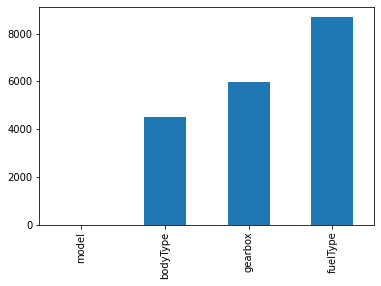

In [36]:
# 缺失值可视化
missing = Train_data.isnull().sum()
missing = missing[missing>0]
missing.sort_values(inplace=True)
missing.plot.bar()

<AxesSubplot: >

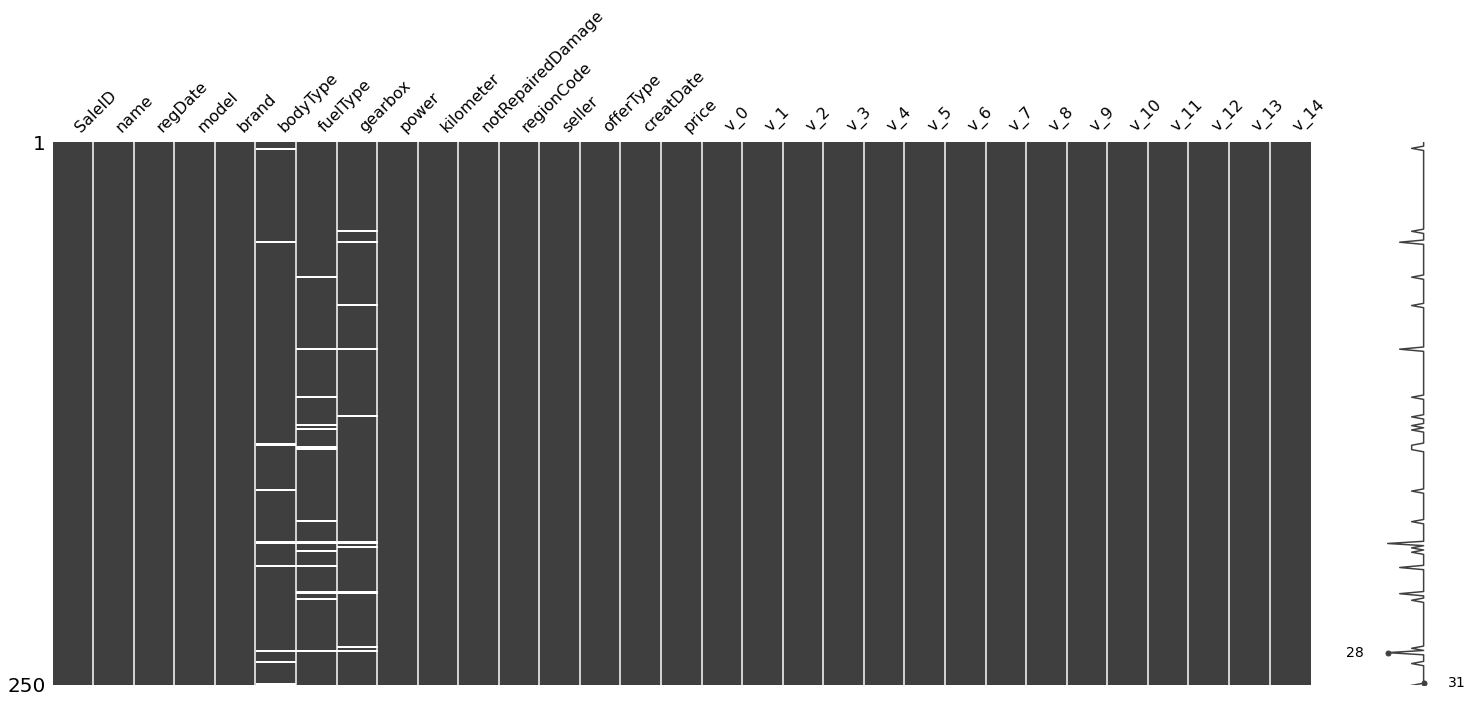

In [43]:
import missingno as msno
msno.matrix(Train_data.sample(250))

<AxesSubplot: >

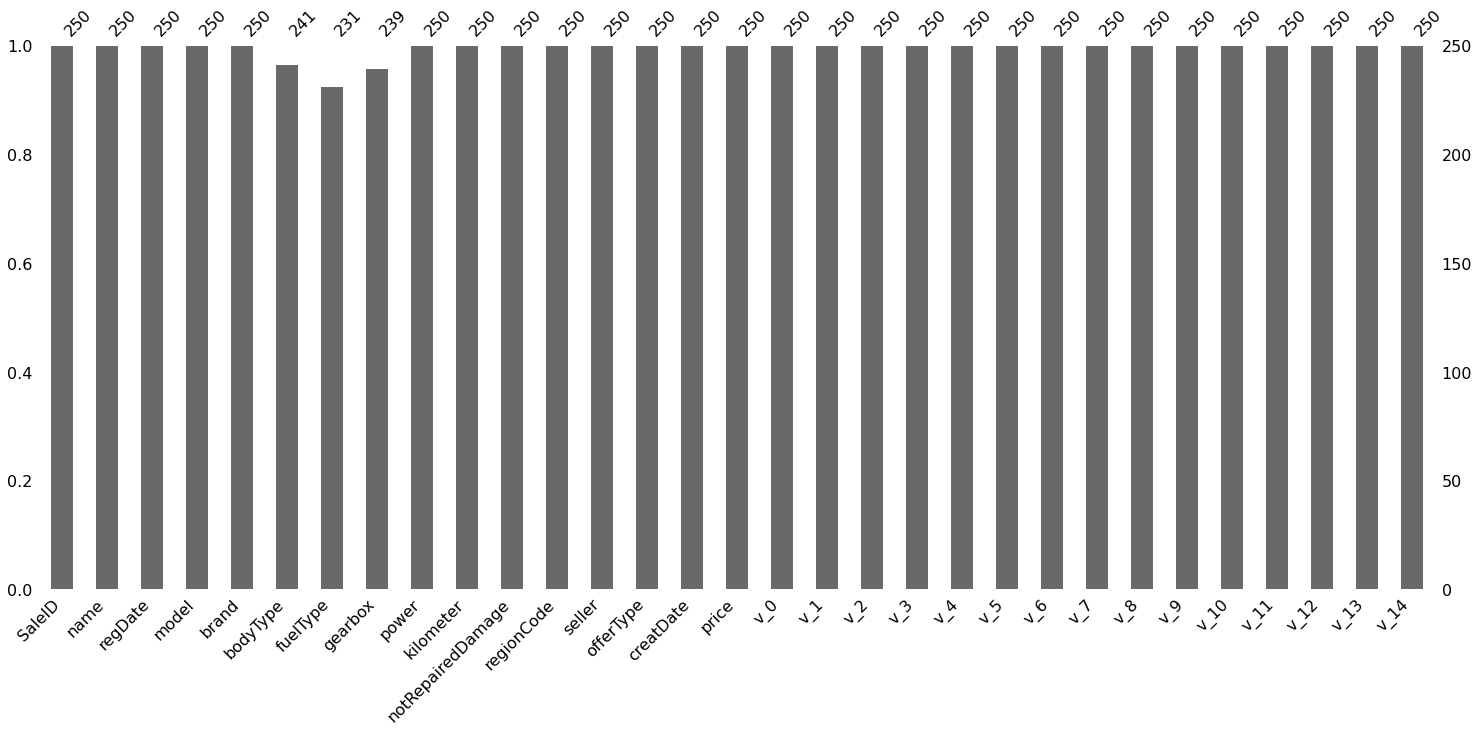

In [44]:
msno.bar(Train_data.sample(250))

In [46]:
# 检查Object类别分布
Train_data['notRepairedDamage'].value_counts()

0.0    111361
-       24324
1.0     14315
Name: notRepairedDamage, dtype: int64

In [47]:
Train_data['notRepairedDamage'].replace('-',np.nan,inplace=True)
Train_data['notRepairedDamage'].value_counts()

0.0    111361
1.0     14315
Name: notRepairedDamage, dtype: int64

In [48]:
Train_data.isnull().sum()

SaleID                   0
name                     0
regDate                  0
model                    1
brand                    0
bodyType              4506
fuelType              8680
gearbox               5981
power                    0
kilometer                0
notRepairedDamage    24324
regionCode               0
seller                   0
offerType                0
creatDate                0
price                    0
v_0                      0
v_1                      0
v_2                      0
v_3                      0
v_4                      0
v_5                      0
v_6                      0
v_7                      0
v_8                      0
v_9                      0
v_10                     0
v_11                     0
v_12                     0
v_13                     0
v_14                     0
dtype: int64

In [54]:
Train_data['seller'].value_counts()

0    149999
1         1
Name: seller, dtype: int64

In [56]:
Train_data['offerType'].value_counts()
# 类似于Seller和offerType这类字段，特征分布严重倾斜
# 一般不会对预测有帮助因此可以删掉

0    150000
Name: offerType, dtype: int64

<AxesSubplot: title={'center': 'Log Normal'}, xlabel='price'>

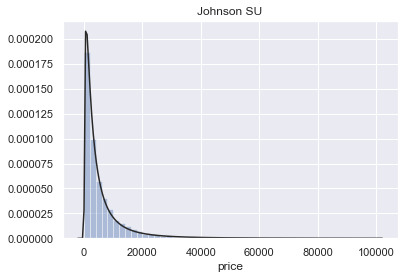

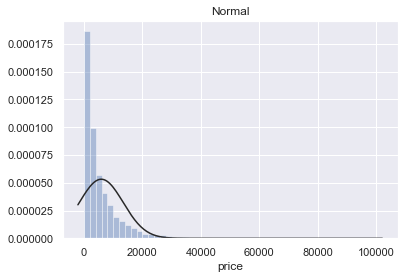

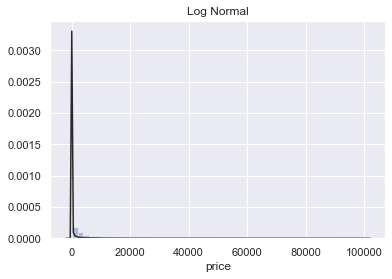

In [57]:
# 1) 总体分布概况（无界约翰逊分布等）
import scipy.stats as st
y = Train_data['price']

plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=st.johnsonsu)

plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)

plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)

Skewness: 3.346487
Kurtosis: 18.995183


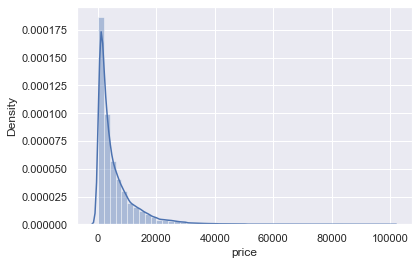

In [62]:
sns.distplot(Train_data['price'])
print("Skewness: %f" % Train_data['price'].skew())
print("Kurtosis: %f" % Train_data['price'].kurt())

SaleID ... done
name ... done
regDate ... done
model ... done
brand ... done
bodyType ... done
fuelType ... done
gearbox ... done
power ... done
kilometer ... done
regionCode ... done
seller ... done
offerType ... done
creatDate ... done
price ... done
v_0 ... done
v_1 ... done
v_2 ... done
v_3 ... done
v_4 ... done
v_5 ... done
v_6 ... done
v_7 ... done
v_8 ... done
v_9 ... done
v_10 ... done
v_11 ... done
v_12 ... done
v_13 ... done
v_14 ... done


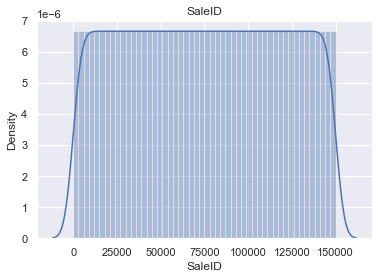

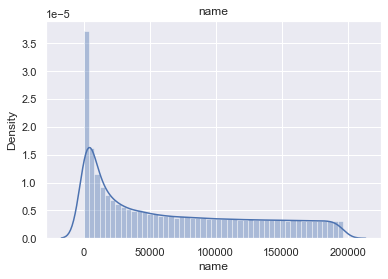

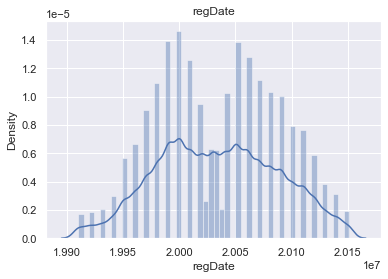

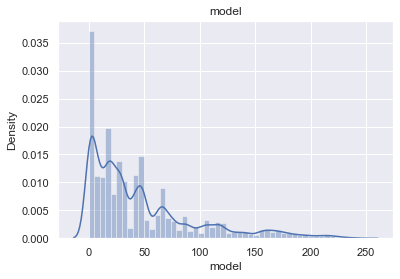

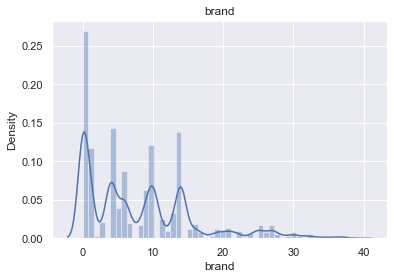

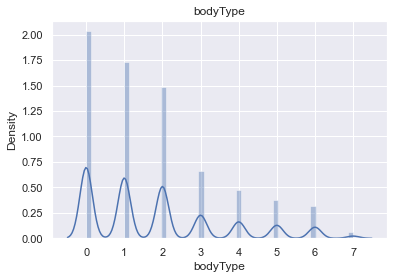

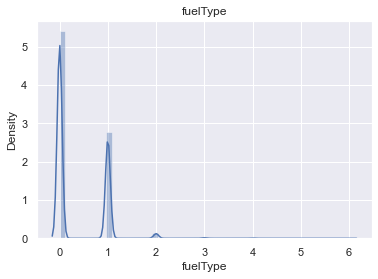

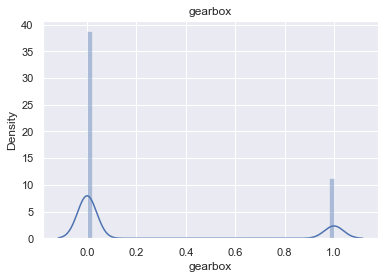

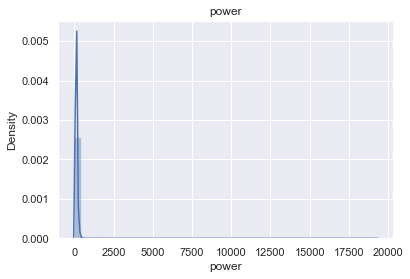

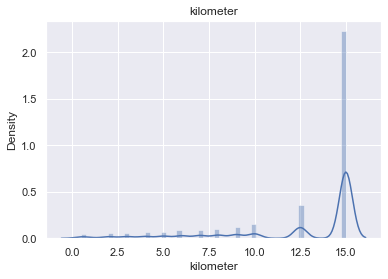

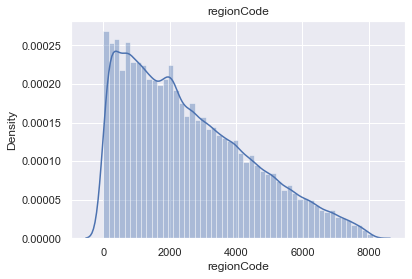

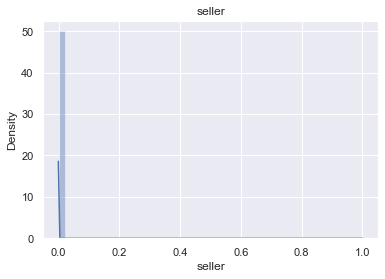

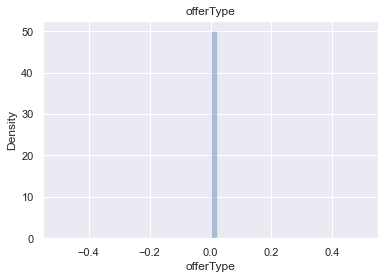

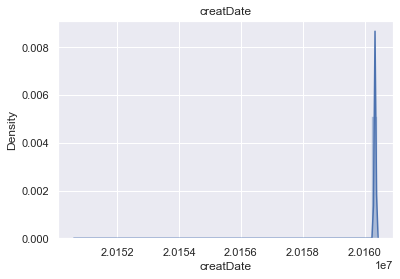

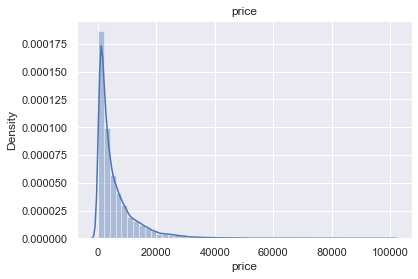

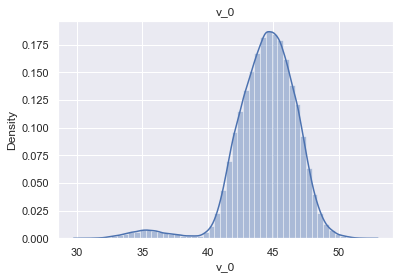

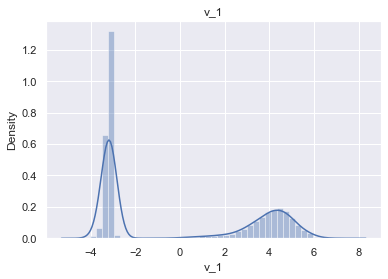

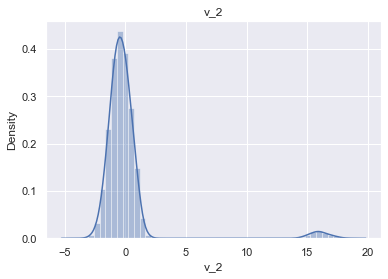

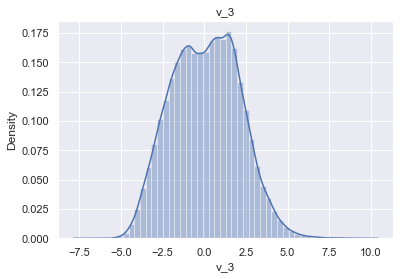

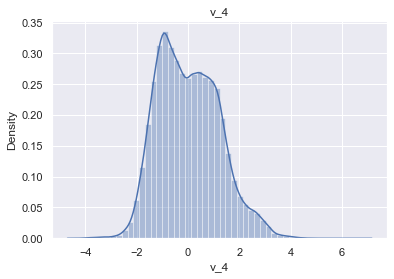

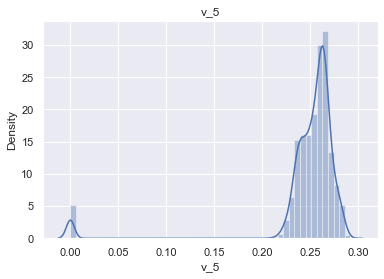

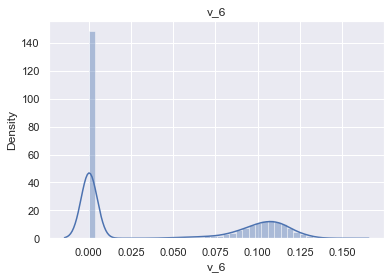

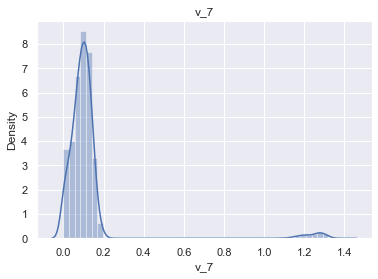

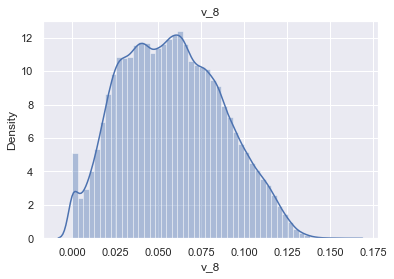

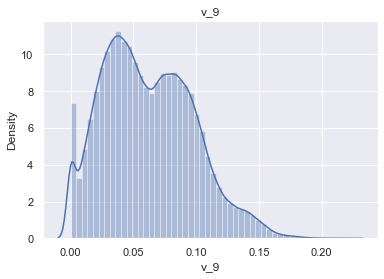

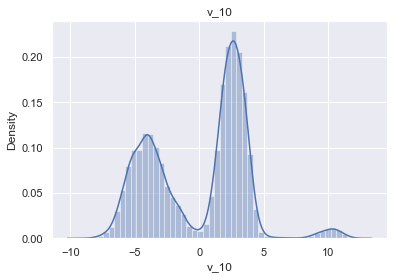

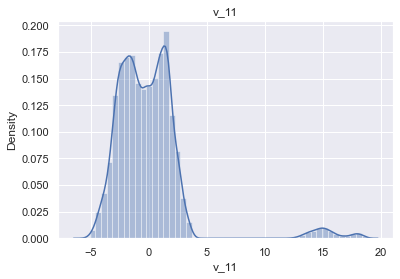

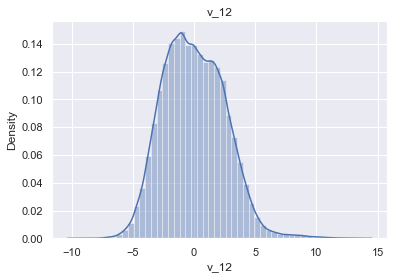

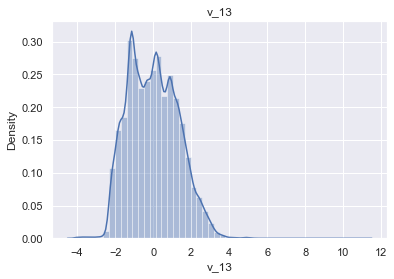

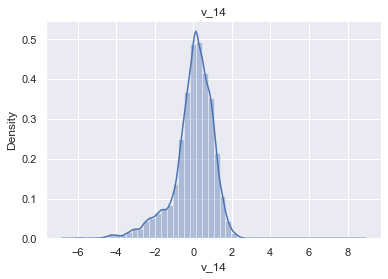

In [67]:
chartindex = 1
for i in numerical_cols:
    print(i,'... done')
    plt.figure(chartindex); plt.title(i)
    chartindex+=1
    sns.distplot(Train_data[i])

In [61]:
# 偏度（skewness），是统计数据分布偏斜方向和程度的度量，
# 是统计数据分布非对称程度的数字特征,表征概率分布密度曲线相对于平均值[不对称程度]的特征数
Train_data.skew()

SaleID                 0.000000
name                   0.557606
regDate                0.028495
model                  1.484388
brand                  1.150760
bodyType               0.991530
fuelType               1.595486
gearbox                1.317514
power                 65.863178
kilometer             -1.525921
notRepairedDamage      2.430640
regionCode             0.688881
seller               387.298335
offerType              0.000000
creatDate            -79.013310
price                  3.346487
v_0                   -1.316712
v_1                    0.359454
v_2                    4.842556
v_3                    0.106292
v_4                    0.367989
v_5                   -4.737094
v_6                    0.368073
v_7                    5.130233
v_8                    0.204613
v_9                    0.419501
v_10                   0.025220
v_11                   3.029146
v_12                   0.365358
v_13                   0.267915
v_14                  -1.186355
dtype: f

In [60]:
# 峰度是描述某变量所有取值分布形态陡缓程度的统计量，简单来说就是数据分布顶的[尖锐程度]
Train_data.kurt()

SaleID                   -1.200000
name                     -1.039945
regDate                  -0.697308
model                     1.740483
brand                     1.076201
bodyType                  0.206937
fuelType                  5.880049
gearbox                  -0.264161
power                  5733.451054
kilometer                 1.141934
notRepairedDamage         3.908072
regionCode               -0.340832
seller               150000.000000
offerType                 0.000000
creatDate              6881.080328
price                    18.995183
v_0                       3.993841
v_1                      -1.753017
v_2                      23.860591
v_3                      -0.418006
v_4                      -0.197295
v_5                      22.934081
v_6                      -1.742567
v_7                      25.845489
v_8                      -0.636225
v_9                      -0.321491
v_10                     -0.577935
v_11                     12.568731
v_12                

<AxesSubplot: xlabel='price', ylabel='Density'>

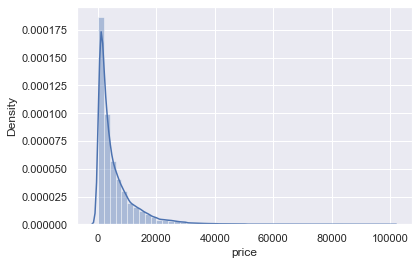

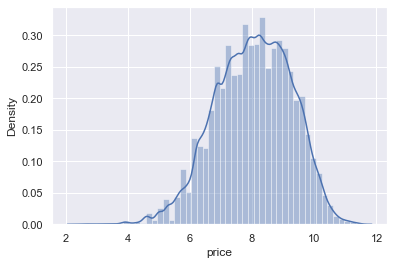

In [69]:
plt.figure(1)
sns.distplot(Train_data['price'])
plt.figure(2)
sns.distplot(np.log(Train_data['price']))

In [71]:
numeric_features = ['power','kilometer','v_0','v_1','v_2','v_3','v_4','v_5','v_6','v_7','v_8','v_9','v_10','v_11','v_12','v_13','v_14','price']
categorical_features = ['SaleID','name','regDate','model','brand','bodyType','fuelType','gearbox','notRepairedDamage','regionCode','seller','offerType','createData']

for cat_fea in categorical_features:
    print(cat_fea,'特征分布如下：')
    print('{}特征有{}个不同的值'.format(cat_fea, Train_data[cat_fea].nunique()))
    print(Train_data[cat_fea].value_counts)

SaleID 特征分布如下：
SaleID特征有150000个不同的值
<bound method IndexOpsMixin.value_counts of 0              0
1              1
2              2
3              3
4              4
           ...  
149995    149995
149996    149996
149997    149997
149998    149998
149999    149999
Name: SaleID, Length: 150000, dtype: int64>
name 特征分布如下：
name特征有99662个不同的值
<bound method IndexOpsMixin.value_counts of 0            736
1           2262
2          14874
3          71865
4         111080
           ...  
149995    163978
149996    184535
149997    147587
149998     45907
149999    177672
Name: name, Length: 150000, dtype: int64>
regDate 特征分布如下：
regDate特征有3894个不同的值
<bound method IndexOpsMixin.value_counts of 0         20040402
1         20030301
2         20040403
3         19960908
4         20120103
            ...   
149995    20000607
149996    20091102
149997    20101003
149998    20060312
149999    19990204
Name: regDate, Length: 150000, dtype: int64>
model 特征分布如下：
model特征有248个不同的值
<bound method IndexO

KeyError: 'createData'

In [75]:
# 相关性分析 - 数值型变量和Price的相关性
correlation = Train_data[numeric_features].corr()
print(correlation['price'].sort_values(ascending=False))

price        1.000000
v_12         0.692823
v_8          0.685798
v_0          0.628397
power        0.219834
v_5          0.164317
v_2          0.085322
v_6          0.068970
v_1          0.060914
v_14         0.035911
v_13        -0.013993
v_7         -0.053024
v_4         -0.147085
v_9         -0.206205
v_10        -0.246175
v_11        -0.275320
kilometer   -0.440519
v_3         -0.730946
Name: price, dtype: float64


<AxesSubplot: title={'center': 'Correlation of Numeric Features'}>

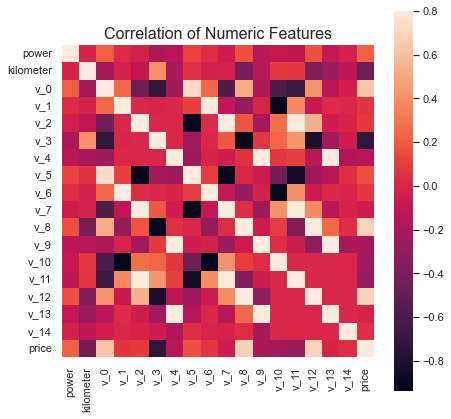

In [77]:
f,ax = plt.subplots(figsize=(7,7))
plt.title('Correlation of Numeric Features',y=1,size=16)
sns.heatmap(correlation,square = True, vmax=0.8)

In [79]:
## 2) 查看几个特征得 偏度和峰值
for col in numeric_features:
     print('{:15}'.format(col), 
 'Skewness: {:05.2f}'.format(Train_data[col].skew()) , 
 ' ' ,
 'Kurtosis: {:06.2f}'.format(Train_data[col].kurt()) 
 )

power           Skewness: 65.86   Kurtosis: 5733.45
kilometer       Skewness: -1.53   Kurtosis: 001.14
v_0             Skewness: -1.32   Kurtosis: 003.99
v_1             Skewness: 00.36   Kurtosis: -01.75
v_2             Skewness: 04.84   Kurtosis: 023.86
v_3             Skewness: 00.11   Kurtosis: -00.42
v_4             Skewness: 00.37   Kurtosis: -00.20
v_5             Skewness: -4.74   Kurtosis: 022.93
v_6             Skewness: 00.37   Kurtosis: -01.74
v_7             Skewness: 05.13   Kurtosis: 025.85
v_8             Skewness: 00.20   Kurtosis: -00.64
v_9             Skewness: 00.42   Kurtosis: -00.32
v_10            Skewness: 00.03   Kurtosis: -00.58
v_11            Skewness: 03.03   Kurtosis: 012.57
v_12            Skewness: 00.37   Kurtosis: 000.27
v_13            Skewness: 00.27   Kurtosis: -00.44
v_14            Skewness: -1.19   Kurtosis: 002.39
price           Skewness: 03.35   Kurtosis: 019.00


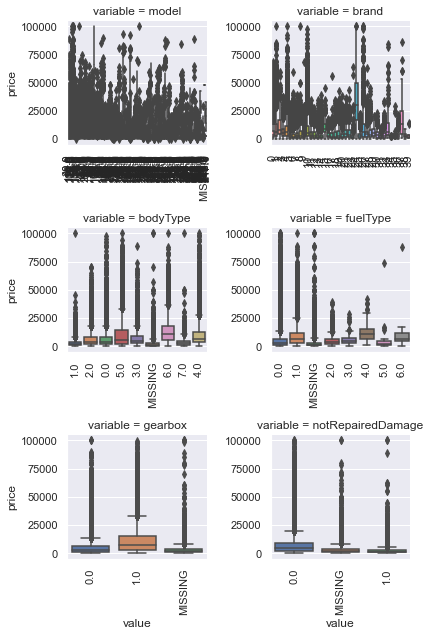

In [88]:
#  因为 name和 regionCode的类别太稀疏了，这里我们把不稀疏的几类画一下
categorical_features = ['model',
                        'brand',
                        'bodyType',
                        'fuelType',
                        'gearbox',
                        'notRepairedDamage']
for c in categorical_features:
    Train_data[c] = Train_data[c].astype('category')
    if Train_data[c].isnull().any():
        Train_data[c] = Train_data[c].cat.add_categories(['MISSING'])
        Train_data[c] = Train_data[c].fillna('MISSING')
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)

f = pd.melt(Train_data, id_vars=['price'], value_vars=categorical_features)
g = sns.FacetGrid(f, col="variable", col_wrap=2, sharex=False, sharey=False)
g = g.map(boxplot, "value", "price")

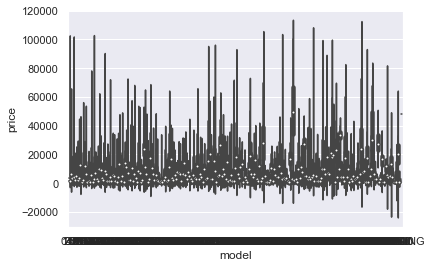

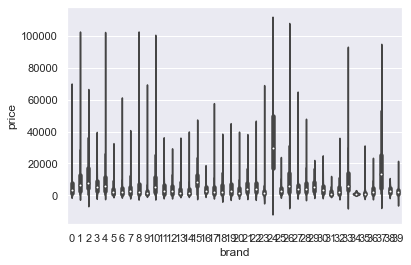

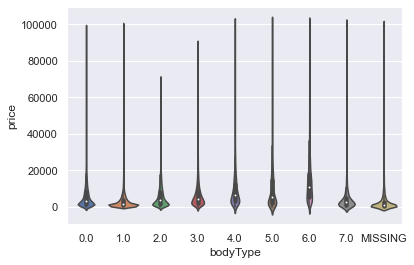

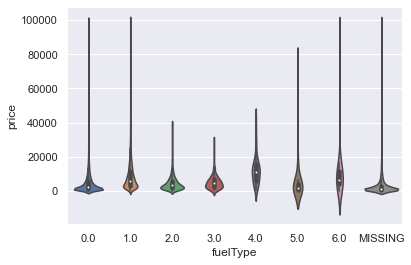

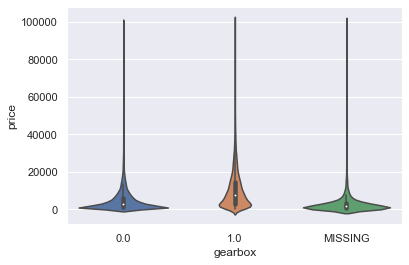

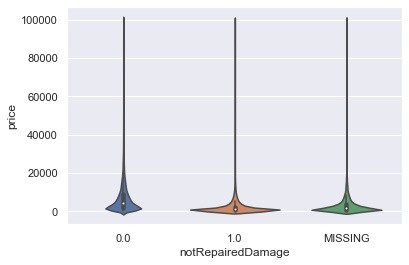

In [85]:
## 3) 类别特征的小提琴图可视化
catg_list = categorical_features
target = 'price'
for catg in catg_list :
    sns.violinplot(x=catg, y=target, data=Train_data)
    plt.show()

In [91]:
import pandas_profiling
pfr = pandas_profiling.ProfileReport(Train_data)
pfr.to_file("./example.html")

Export report to file: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


特征工程
常见的特征工程包括：
1. 异常处理：
    - 通过箱线图（或 3-Sigma）分析删除异常值；
    - BOX-COX 转换（处理有偏分布）；
    - 长尾截断；
2. 特征归一化/标准化：
    - 标准化（转换为标准正态分布）；
    - 归一化（抓换到 [0,1] 区间）；
    - 针对幂律分布，可以采用公式：
3. 数据分桶：
    - 等频分桶；
    - 等距分桶；
    - Best-KS 分桶（类似利用基尼指数进行二分类）；
    - 卡方分桶；
4. 缺失值处理：
    - 不处理（针对类似 XGBoost 等树模型）；
    - 删除（缺失数据太多）；
    - 插值补全，包括均值/中位数/众数/建模预测/多重插补/压缩感知补全/矩阵补全等；
    - 分箱，缺失值一个箱；
5. 特征构造：
    - 构造统计量特征，报告计数、求和、比例、标准差等；
    - 时间特征，包括相对时间和绝对时间，节假日，双休日等；
    - 地理信息，包括分箱，分布编码等方法；
    - 非线性变换，包括 log/ 平方/ 根号等；
    - 特征组合，特征交叉；
    - 仁者见仁，智者见智
6. 特征筛选
    - 过滤式（filter）：先对数据进行特征选择，然后在训练学习器，常见的方法有 Relief/方差选择发/相关系
    - 数法/卡方检验法/互信息法；
    - 包裹式（wrapper）：直接把最终将要使用的学习器的性能作为特征子集的评价准则，常见方法有
    - LVM（Las Vegas Wrapper） ；
    - 嵌入式（embedding）：结合过滤式和包裹式，学习器训练过程中自动进行了特征选择，常见的有
    - lasso 回归；
7. 降维
    - PCA/ LDA/ ICA；
    - 特征选择也是一种降维

In [92]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter
%matplotlib inline

In [93]:
# 这里我包装了一个异常值处理的代码，可以随便调用。
def outliers_proc(data, col_name, scale=3):
    """
    用于清洗异常值，默认用 box_plot（scale=3）进行清洗
    :param data: 接收 pandas 数据格式
    :param col_name: pandas 列名
    :param scale: 尺度
    :return:
    """
    def box_plot_outliers(data_ser, box_scale):
        """
        利用箱线图去除异常值
        :param data_ser: 接收 pandas.Series 数据格式
        :param box_scale: 箱线图尺度，
        :return:
        """
        iqr = box_scale * (data_ser.quantile(0.75) - data_ser.quantile(0.25))
        val_low = data_ser.quantile(0.25) - iqr
        val_up = data_ser.quantile(0.75) + iqr
        rule_low = (data_ser < val_low)
        rule_up = (data_ser > val_up)
        return (rule_low, rule_up), (val_low, val_up)
    
    data_n = data.copy()
    data_series = data_n[col_name]
    rule, value = box_plot_outliers(data_series, box_scale=scale)
    index = np.arange(data_series.shape[0])[rule[0] | rule[1]]
    print("Delete number is: {}".format(len(index)))
    data_n = data_n.drop(index)
    data_n.reset_index(drop=True, inplace=True)
    print("Now column number is: {}".format(data_n.shape[0]))
    index_low = np.arange(data_series.shape[0])[rule[0]]
    outliers = data_series.iloc[index_low]
    print("Description of data less than the lower bound is:")
    print(pd.Series(outliers).describe())
    index_up = np.arange(data_series.shape[0])[rule[1]]
    outliers = data_series.iloc[index_up]
    print("Description of data larger than the upper bound is:")
    print(pd.Series(outliers).describe())

    fig, ax = plt.subplots(1, 2, figsize=(10, 7))
    sns.boxplot(y=data[col_name], data=data, palette="Set1", ax=ax[0])
    sns.boxplot(y=data_n[col_name], data=data_n, palette="Set1", ax=ax[1])
    return data_n

In [94]:
train = pd.read_csv('datasource/used_car_train_20200313.csv', sep=' ')
print(train.shape)

(150000, 31)


Delete number is: 963
Now column number is: 149037
Description of data less than the lower bound is:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: power, dtype: float64
Description of data larger than the upper bound is:
count      963.000000
mean       846.836968
std       1929.418081
min        376.000000
25%        400.000000
50%        436.000000
75%        514.000000
max      19312.000000
Name: power, dtype: float64


,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149032,149995,163978,20000607,121.0,10,4.0,0.0,1.0,163,15.0,...,0.280264,0.000310,0.048441,0.071158,0.019174,1.988114,-2.983973,0.589167,-1.304370,-0.302592
149033,149996,184535,20091102,116.0,11,0.0,0.0,0.0,125,10.0,...,0.253217,0.000777,0.084079,0.099681,0.079371,1.839166,-2.774615,2.553994,0.924196,-0.272160
149034,149997,147587,20101003,60.0,11,1.0,1.0,0.0,90,6.0,...,0.233353,0.000705,0.118872,0.100118,0.097914,2.439812,-1.630677,2.290197,1.891922,0.414931
149035,149998,45907,20060312,34.0,10,3.0,1.0,0.0,156,15.0,...,0.256369,0.000252,0.081479,0.083558,0.081498,2.075380,-2.633719,1.414937,0.431981,-1.659014


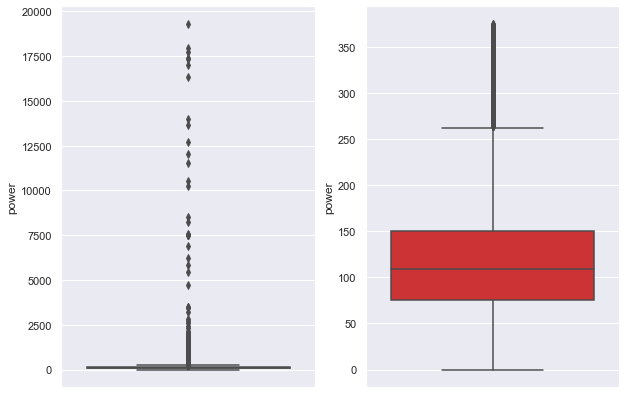

In [95]:
outliers_proc(train,'power',scale=3)

- 对于知道特征含义（非匿名）的特征工程，特别是在工业类型比赛中，会基于信号处理，频域提取，峰度，偏度等构建更为有实际意义的特征，这就是结合背景的特征构建，在推荐系统中也是这样的，各种类型点击率统计，各时段统计，加用户属性的统计等等，这样一种特征构建往往要深入分析背后的业务逻辑或者说物理原理，从而才能更好的找到 magic。
- 当然特征工程其实是和模型结合在一起的，这就是为什么要为 LR NN 做分桶和特征归一化的原因，而对于特征的处理效果和特征重要性等往往要通过模型来验证。
- 总的来说，特征工程是一个入门简单，但想精通非常难的一件事。